This notebook uses `PIL`, `pytesseract`, and `pandas` to read image files, convert image to text, and convert text to dataframes.

In [213]:
import os
import re
import pytesseract
from PIL import Image
import pandas as pd
from datetime import datetime

In [214]:
filenames = os.listdir('crossword_images')

# remove weird files
regex = re.compile('^\.')
filenames = [i for i in filenames if not regex.match(i)]

# preview filenames
filenames[0:5]

['Screen Shot 2019-12-16 at 8.40.26 PM.png',
 'image (26).png',
 'image (30).png',
 'image (47).png',
 'image (10).png']

In [267]:
def load_image(filename):
    ''' read in the images '''
    image = Image.open(filename)
    return image


def extract_text(image):
    ''' convert images to text'''
    text = pytesseract.image_to_string(image)
    return text


def get_date(text):
    ''' pull out the date in datetime format '''
    # get the date
    p = re.compile('\,\s*([a-zA-Z]*\s[0-9]{1,2}\,\s[0-9]{4})')

    date_string = p.search(text, re.MULTILINE)
    print(date_string)
    
    # group 2 returns the second parenthesis group in the pattern, ignoring the dow
    if date_string is None:
        date = None
    else:
        date = datetime.strptime(date_string.group(1), "%B %d, %Y") 
    return date


def get_seconds(text):
    ''' pull out the results in seconds as a list'''
    p = re.compile('[0-9]{1,2}:[0-9]{2}')
    results = p.findall(text, re.MULTILINE)
    
#     print (results)
    seconds = []
    for result in results:
        seconds = seconds + [
            (int(str.split(result, ':')[0]) * 60) + 
            int(str.split(result, ':')[1]) 
        ]
    return seconds


def get_players(text):
    ''' pull out the player names as a list'''
    # suppress the header
    p_header = re.compile('.*\\n\\n.*\\n\\n.*\s[0-9]{4}\\n', re.MULTILINE)
    body = p_header.sub(string=text, repl='')
    # if times are remaining, exclude those too
    p_times = re.compile('[0-9]{1,2}:[0-9]{2}', re.MULTILINE)
    body_2 = p_times.sub(string = body, repl = '')
    
    players = str.split(body_2, '\n')
    # remove empty entries
    players = [i for i in players if i] 

    return players


def create_result_df(date, player_list, seconds_list):
    ''' 
    take the stuff from above, make a dataframe. 
    if the extracted data is of different lengths,
    match all we can starting with the first one
    '''
    
    max_len = max(len(player_list), len(seconds_list))
    # make the date appear n times
    date_list =  [ele for ele in [date] for i in range(max_len)]
    
    # zip will return results the length of the shortest list
    data_tuples = list(zip(date_list, players_list, secs_list))
    
    df = pd.DataFrame(data_tuples)
    df = df.rename(columns={0: 'date', 1: 'player', 2: 'seconds'})
    return(df)
        
            


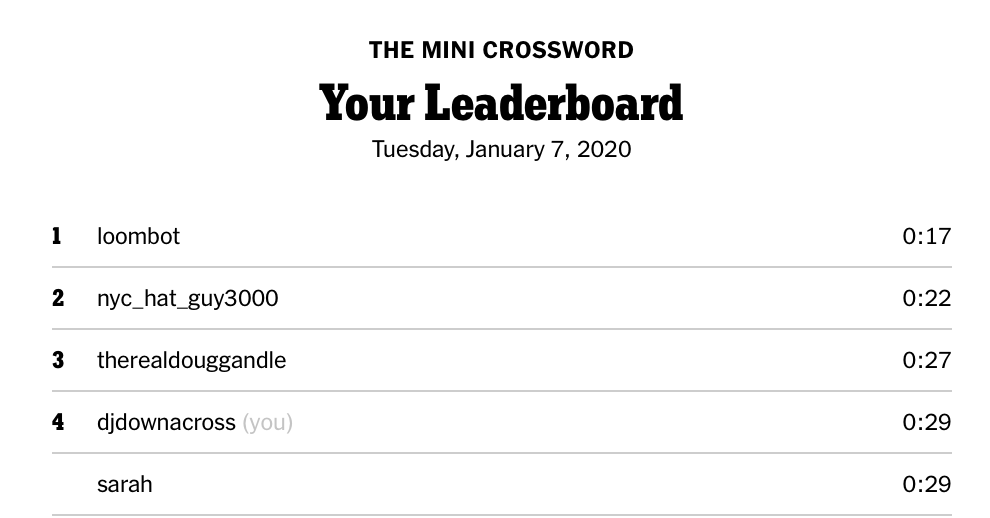

In [268]:
img = load_image('crossword_images/' + filenames[60])
img

In [269]:
txt = extract_text(img)
date = get_date(txt)
secs_list = get_seconds(txt)
players_list = get_players(txt)
df = create_result_df(date, secs_list, players_list)

<re.Match object; span=(45, 62), match=', January 7, 2020'>


In [270]:
txt

'THE MINI CROSSWORD\n\nYour Leaderboard\n\nTuesday, January 7, 2020\n\nloombot\nnyc_hat_guy3000\ntherealdouggandle\ndjdownacross\n\nsarah\n\n0:17\n\n0:22\n\n0:27\n\n0:29\n\n0:29'

In [271]:
date

datetime.datetime(2020, 1, 7, 0, 0)

In [272]:
secs_list

[17, 22, 27, 29, 29]

In [273]:
players_list

['loombot', 'nyc_hat_guy3000', 'therealdouggandle', 'djdownacross', 'sarah']

In [274]:
df

,date,player,seconds
0,2020-01-07,loombot,17
1,2020-01-07,nyc_hat_guy3000,22
2,2020-01-07,therealdouggandle,27
3,2020-01-07,djdownacross,29
4,2020-01-07,sarah,29


In [275]:
dfs = []

for file in filenames:
    print('---------------------')
    print(file)
    img = load_image('crossword_images/' + file)
    txt = extract_text(img)
    print(txt)
    date = get_date(txt)
    print(date)
    secs_list = get_seconds(txt)
    print(secs_list)
    players_list = get_players(txt)
    print(players_list)
    df = create_result_df(date, secs_list, players_list)
    
    dfs.append(df)
    




df_final = pd.concat(dfs)



---------------------
Screen Shot 2019-12-16 at 8.40.26 PM.png
THE MINI CROSSWORD
Your Leaderboard
Monday, December 16, 2019
sarah
loombot
djdownacross

therealdouggandle

Settings Add Friends

0:38

0:39

1:27

1:32
<re.Match object; span=(42, 61), match=', December 16, 2019'>
2019-12-16 00:00:00
[38, 39, 87, 92]
['THE MINI CROSSWORD', 'Your Leaderboard', 'Monday, December 16, 2019', 'sarah', 'loombot', 'djdownacross', 'therealdouggandle', 'Settings Add Friends']
---------------------
image (26).png
THE MINI CROSSWORD
Your Leaderboard
Thursday, September 5, 2019
1 sarah 0:21
2 ~ loombot 0:44

3 = djdownacross 2:30
<re.Match object; span=(44, 63), match=', September 5, 2019'>
2019-09-05 00:00:00
[21, 44, 150]
['THE MINI CROSSWORD', 'Your Leaderboard', 'Thursday, September 5, 2019', '1 sarah ', '2 ~ loombot ', '3 = djdownacross ']
---------------------
image (30).png
THE MINI CROSSWORD

Your Leaderboard

Friday, August 23, 2019

samelia
nyc_hat_guy3000
loombot

djdownacross

0:28

0:30


In [277]:
df_final.head(20)

,date,player,seconds
0,2019-12-16,THE MINI CROSSWORD,38
1,2019-12-16,Your Leaderboard,39
2,2019-12-16,"Monday, December 16, 2019",87
3,2019-12-16,sarah,92
0,2019-09-05,THE MINI CROSSWORD,21
1,2019-09-05,Your Leaderboard,44
2,2019-09-05,"Thursday, September 5, 2019",150
0,2019-08-23,samelia,28
1,2019-08-23,nyc_hat_guy3000,30
2,2019-08-23,loombot,38


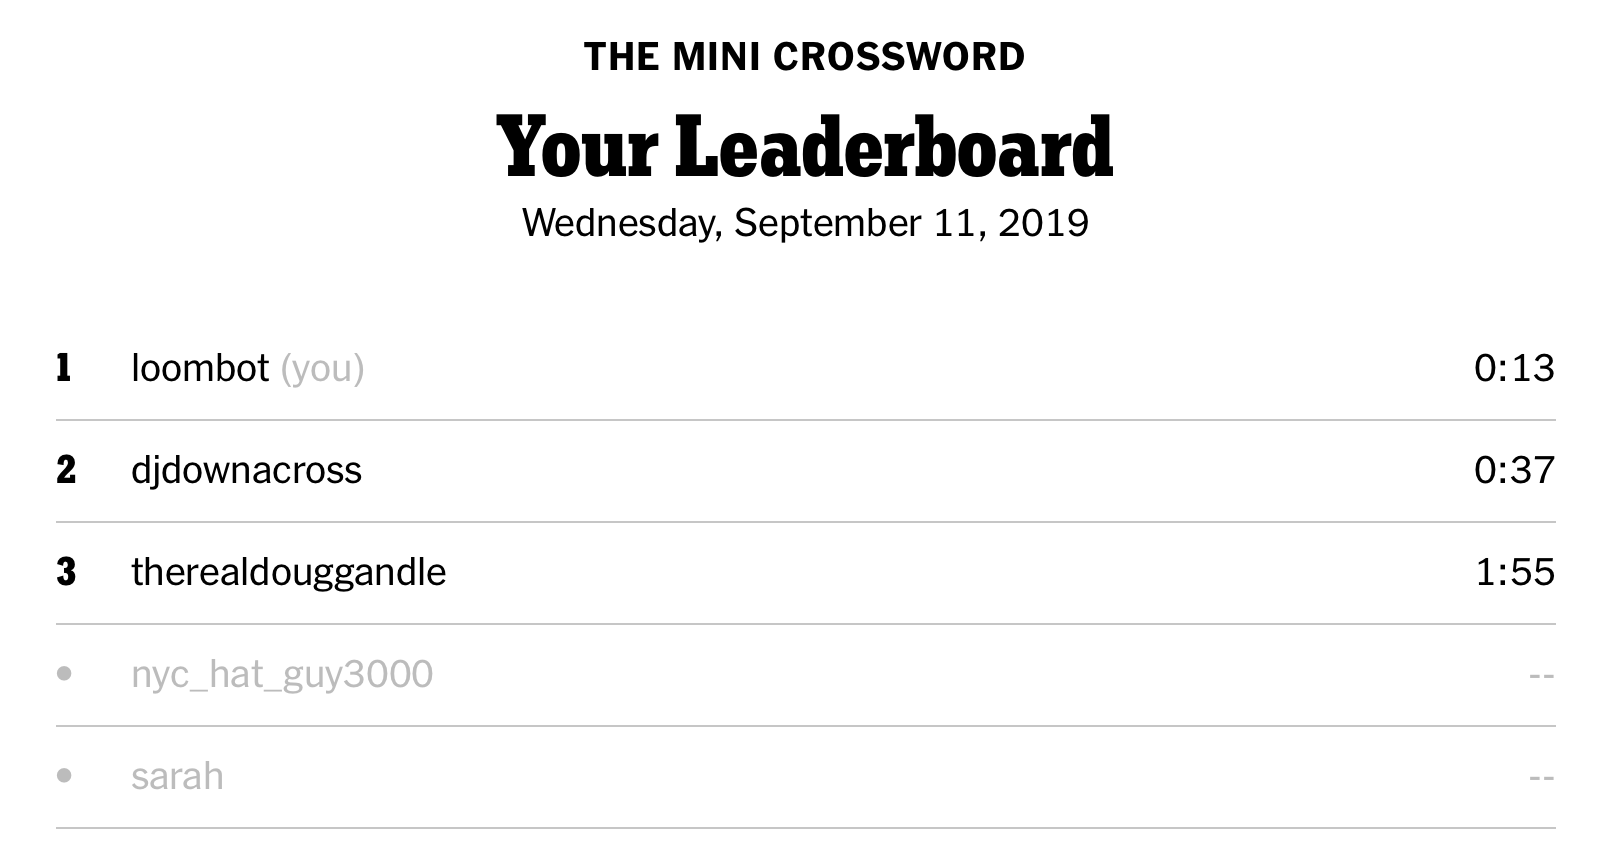

In [282]:
img = load_image('crossword_images/image (25).png')
img

In [283]:
txt = extract_text(img)
txt

'1\n\n2\n\n3\n\nloombot\ndjdownacross\n\ntherealdouggandle\n\nTHE MINI CROSSWORD\n\nYour Leaderboard\n\nWednesday, September 11, 2019'

In [284]:
get_players(txt)

['1',
 '2',
 '3',
 'loombot',
 'djdownacross',
 'therealdouggandle',
 'THE MINI CROSSWORD',
 'Your Leaderboard',
 'Wednesday, September 11, 2019']